# Recopilación de imágenes satelitales de centros de investigación AGROSAVIA

El código a continuación permite recolectar la información satelital disponible de los centros de investigación de Agrosavia distribuidos por todo el territorio nacional. Estas imágenes son recortes de la imágene satelital original que contiene el polígono georeferenciado. Las imágenes son accedidas utilizando el API desarrollado por el proyecto Planetary Computer de Microsoft.

## Carga de librerías Planetary Computer y complementarias

Lo primero que vamos a importar son las librerías de **Planetary computer** y de conexión **pystac**.

In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

Con el fin buscar los centros de investigación en las bases de datos disponibles en **Planetary Computer**, cargaremos los archivos que definen los polígonos georeferenciados de los centros de investigación Agrosavia. Para esto usaremos la librería **fiona**.

In [2]:
import fiona

In [3]:
import rasterio
from rasterio import mask
from rasterio import windows
from rasterio import features
from rasterio import warp
from shapely.geometry import box

In [4]:
file_location="shape_files/linderos_format_4326.shp"
with fiona.open(file_location, "r",) as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
area_of_interest=features.bounds(shapes[1])
area_of_interest=box(*area_of_interest)

Ahora fijamos el intervalo de tiempo, para nuestro caso, buscamos las imágenes disponibles a la fecha.

In [6]:
time_of_interest = "1990-01-01/2021-12-31"

Listamos las imágenes disponibles para el sensor **Landsat** incluyendo las que pueden estar completamente nubladas ("lt":100).

In [7]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["landsat-8-c2-l2"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 100}},
)

Determinamos el número de imágenes disponibles.

In [8]:
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 189 Items


Función que permite encontrar las bandas de la imágen satelital basado en el nombre del archivo.

In [9]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

Función que permite cargar y recortar la imágen disponible en una imagen satelital.

In [10]:
def read_band(href):
    with rasterio.open(href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        return ds.read(1, window=aoi_window)

Función que calcula las etiquetas de pixel de manera automática.

In [15]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def cubes_block(data, S):

    N = S * S      # window pixels number

    Nx, Ny, D = data.shape    # dimensions
    M         = Nx * Ny       # windows number

    data_padd = np.pad(data, [(int((S-1)/2),), (int((S-1)/2),), (0,)], mode='symmetric')    # data padding
    block     = np.zeros((N, M, D))     # block array init

    m = 0   # window index

    # block filling
    for i in range(Nx):
        for j in range(Ny):

            wind           = data_padd[i : i + S, j : j + S, :].copy()
            block[:, m, :] = wind.reshape(N, D)

            m += 1

    return block

def SGMM(X, S, Nc, P, ERR):
    # S               window size
    N     = S * S   # pixels number
    # Nc              clusters number
    # P               iterations number
    # ERR             minimum error

    # odd size checking
    if not S % 2:
          S = S + 1

    Nx, Ny, D  = X.shape     # row length, column lenght, bands number
    M          = Nx * Ny     # samples number

    w     = np.zeros((Nc, M))           # weights (3 per pixel)
    mu    = np.zeros((Nc, D))           # means (1 per cluster)
    sigma = np.zeros((Nc, D, D))        # covariance arrays (1 per cluster)
    gamma = np.random.rand(Nc, M, N)    # latent variable likelihood cubes block

    cube_block = cubes_block(X, S)
    cube_block = np.swapaxes(cube_block, 0, 1)     # data cubes block (M, N, D)

    for p in range(P):

        w_old     = w.copy()
        mu_old    = mu.copy()
        sigma_old = sigma.copy()

        gamma = gamma / np.sum(gamma, 0)[np.newaxis, :]  # normalization of priori

        # weights stimation
        g = np.sum(gamma, 2)
        w = g / N

        gk_sum = np.sum(g, 1)

        # mean stimation
        mu = np.sum((cube_block[np.newaxis]) * (gamma[:, :, :, np.newaxis]), (1, 2)) / (gk_sum[:, np.newaxis])

        # covariance stimation
        t     = cube_block[np.newaxis] - mu[:, np.newaxis, np.newaxis, :]
        sigma = np.sum(np.matmul(np.swapaxes((gamma[:, :, :, np.newaxis]) * t, 2, 3), t), 1) / \
              gk_sum[:, np.newaxis, np.newaxis]

        # latent variable stimation
        gamma = ((w) / ((np.sqrt(np.linalg.det(sigma)))[:, np.newaxis]))[:, :, np.newaxis] * \
              np.exp(-np.sum(t * np.swapaxes(np.matmul(np.linalg.inv(sigma)[:, np.newaxis], np.swapaxes(t, 2, 3)), 2, 3), 3) / 2)

        err = np.linalg.norm(w - w_old) + np.linalg.norm(mu - mu_old) + np.linalg.norm(sigma - sigma_old)

        if p > 1 and err < ERR:
            break

    label = np.argmax(w, 0)
    plt.imshow(label.reshape((Nx, Ny)) + 1, cmap='jet')
    plt.show()
    return label.reshape((Nx, Ny)) + 1

Rutina que carga y guarda el recorte georeferenciado de la zona de interés.

In [11]:
def write_band(href,band_name):
    with rasterio.open(href) as src:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", src.crs, *aoi_bounds)
        shape_mask_bounds=box(*warped_aoi_bounds)
        out_image,out_transform = mask.mask(src,[shape_mask_bounds],crop=True)
        out_meta = src.meta
        out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
        with rasterio.open("img/"+band_name, "w", **out_meta) as dest:
            dest.write(out_image)
            dest.close()
        return out_image

Carga de imágenes de cada banda espectral

In [12]:
selected_item = sorted(items, key=lambda item: eo.ext(item).cloud_cover)[0]  
asset_hrefs = [
    find_asset_by_band_common_name(selected_item, "coastal").href,
    find_asset_by_band_common_name(selected_item, "red").href,
    find_asset_by_band_common_name(selected_item, "green").href,
    find_asset_by_band_common_name(selected_item, "blue").href,
    find_asset_by_band_common_name(selected_item, "swir16").href,
    find_asset_by_band_common_name(selected_item, "swir22").href,
    find_asset_by_band_common_name(selected_item, "lwir11").href
  ]
  
signed_hrefs = [pc.sign(asset_href) for asset_href in asset_hrefs]


bands=[
       write_band(signed_hrefs[0],"coastal"),
       write_band(signed_hrefs[1],"red"),
       write_band(signed_hrefs[2],"green"),
       write_band(signed_hrefs[3],"blue"),
       write_band(signed_hrefs[4],"swir16"),
       write_band(signed_hrefs[5],"swir22"),
       write_band(signed_hrefs[6],"lwir11")
      ]

bands = [read_band(href) for href in signed_hrefs]

#bands.append(label)
#multiband_data = np.stack(bands)

In [16]:
pixeld=np.concatenate((bands[0].reshape((-1,1)),bands[1].reshape((-1,1)),bands[2].reshape((-1,1)),bands[3].reshape((-1,1)),bands[4].reshape((-1,1)),bands[5].reshape((-1,1)),bands[6].reshape((-1,1))),axis=1)

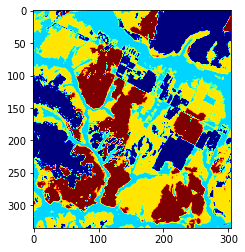

In [17]:
from sklearn import cluster
k_means=cluster.KMeans(n_clusters=4)
_=k_means.fit(pixeld)
X_clustered=k_means.labels_
X_clustered=X_clustered.reshape(bands[0].shape)
plt.imshow(X_clustered, cmap='jet')

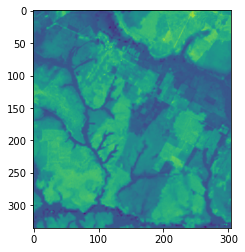

In [18]:
plt.imshow(bands[0])

Etiquetado de pixeles basado en el espectro por pixel.

Guardado de pixeles con etiquetas georeferenciadas.